# Emotion Detection in Sinhala Language Texts in Social Media
## By 2021/E/045 and 2021/E053

In [91]:
#!pip install --upgrade -r requirements.txt

In [92]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="NLPC-UOM/SinBERT-large")
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")
model = AutoModelForMaskedLM.from_pretrained("NLPC-UOM/SinBERT-large")

Device set to use cuda:0


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import cohen_kappa_score


In [94]:
dataset_path='./raw/Dataset.csv'
df = pd.read_csv(dataset_path, encoding='utf-8')
df = df.rename(columns={'Annotator 1': 'emotion_1', 'Annotator 2(Yasitha)': 'emotion_2', 'Phrase': 'text'})
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')]

In [95]:
df.head()

,emotion_1,emotion_2,text
0,joy,joy,නියම සිංහල මහත්මයෙක්.
1,joy,joy,අන්න මිනිස්සු...
2,disgust,anger,හොරා හොද මිනිහෙක් නම් අනේ මහත්තයෝ සමාවෙන්න කිය...
3,NaN,NaN,තව ඩිංගෙන් ලබු ගෙඩියත් කොස් ගෙඩි සහ පොල් ගෙඩි ...
4,disgust,disgust,"බතල වැලට, කොස්ගෙඩි අටට, උසාවි ගිහින් රිමන්ඩ් ක..."


## Data Preprocessing

### Changing the data type of the columns

In [96]:
# Use the renamed columns
df['emotion_2'] = df['emotion_2'].astype(str).str.strip()
df['emotion_1'] = df['emotion_1'].astype(str).str.strip()
df['emotion_2'] = df['emotion_2'].astype('category')
df['emotion_1'] = df['emotion_1'].astype('category')


# Verify the datatypes
print(df.dtypes)

emotion_1    category
emotion_2    category
text           object
dtype: object


In [97]:
df.head()

,emotion_1,emotion_2,text
0,joy,joy,නියම සිංහල මහත්මයෙක්.
1,joy,joy,අන්න මිනිස්සු...
2,disgust,anger,හොරා හොද මිනිහෙක් නම් අනේ මහත්තයෝ සමාවෙන්න කිය...
3,nan,nan,තව ඩිංගෙන් ලබු ගෙඩියත් කොස් ගෙඩි සහ පොල් ගෙඩි ...
4,disgust,disgust,"බතල වැලට, කොස්ගෙඩි අටට, උසාවි ගිහින් රිමන්ඩ් ක..."


### Cohen's Kappa Score

In [98]:
cohen_kappa_score(df['emotion_1'], df['emotion_2'])

0.796194703329417

In [99]:
string_cols = ['emotion_1', 'emotion_2']  # Add any other relevant string columns

for col in string_cols:
    df[col] = df[col].astype(str).str.replace(r'\s+', ' ', regex=True)  # normalize multiple spaces to one
    df[col] = df[col].str.strip()

In [100]:
df[''] = (
    df['emotion_1']
    .astype(str)
    .str.strip()              # remove leading/trailing spaces
    .str.replace(r'\s+', ' ', regex=True)  # collapse internal whitespace
    .str.lower()              # unify casing (optional)
)
df[''] = (
    df['emotion_2']
    .astype(str)
    .str.strip()              # remove leading/trailing spaces
    .str.replace(r'\s+', ' ', regex=True)  # collapse internal whitespace
    .str.lower()              # unify casing (optional)
)
# 3. Consolidate duplicate “disgust” entries
#    Any “disgust” (with or without stray spaces) now maps to canonical 'disgust'

In [101]:
counts1 = df['emotion_1'].value_counts()
small_labels = counts1[counts1 < 10].index.tolist()  # threshold = 10
df = df[~df['emotion_1'].isin(small_labels)]

counts2 = df['emotion_2'].value_counts()
small_labels2 = counts2[counts2 < 10].index.tolist()  # threshold = 10
df = df[~df['emotion_2'].isin(small_labels2)]

ano_1_count = df['emotion_1'].value_counts()
ano_2_count =df['emotion_2'].value_counts()
print(f" Annontator 1 -> {ano_1_count} \n\n Annontator 2 -> {ano_2_count}")

 Annontator 1 -> emotion_1
nan         7392
joy          804
fear         658
disgust      642
sadness      552
surprise     533
anger        520
Name: count, dtype: int64 

 Annontator 2 -> emotion_2
nan         6806
joy          930
disgust      748
fear         695
sadness      676
anger        629
surprise     590
Sadness       16
Joy           11
Name: count, dtype: int64


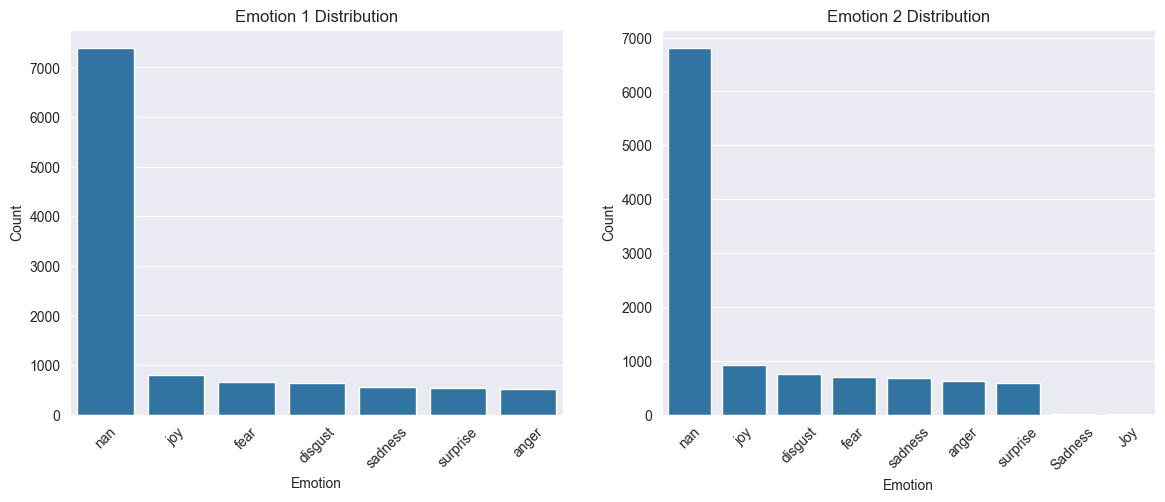

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(ax=axes[0], x='emotion_1', data=df, order=df['emotion_1'].value_counts().index)
axes[0].set_title('Emotion 1 Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[1], x='emotion_2', data=df, order=df['emotion_2'].value_counts().index)
axes[1].set_title('Emotion 2 Distribution')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)


plt.show()

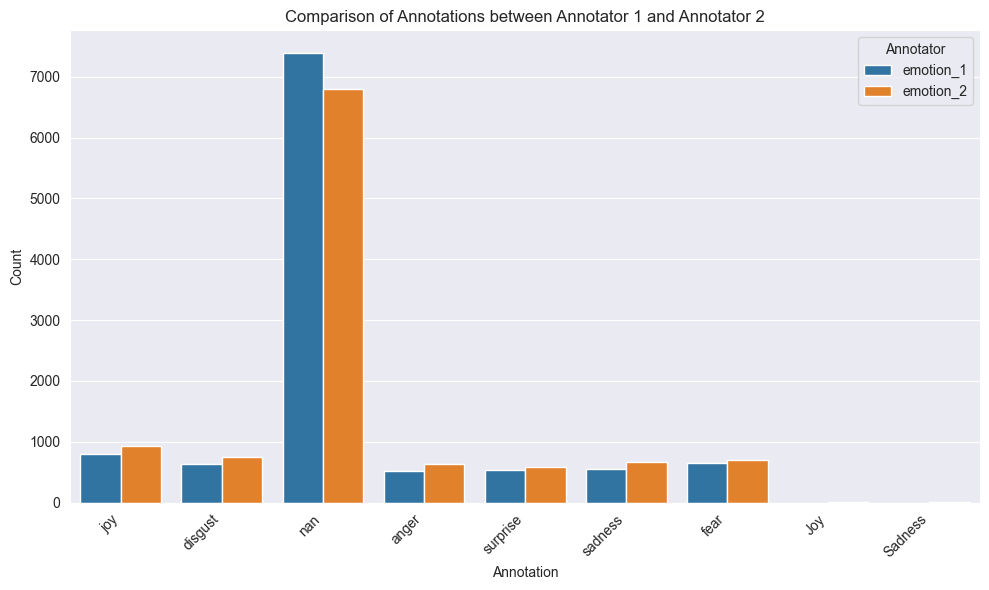

In [103]:
dataset_melted = df[['emotion_1', 'emotion_2']].melt(var_name='Annotator', value_name='Annotation')

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset_melted, x='Annotation', hue='Annotator')
plt.title('Comparison of Annotations between Annotator 1 and Annotator 2')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

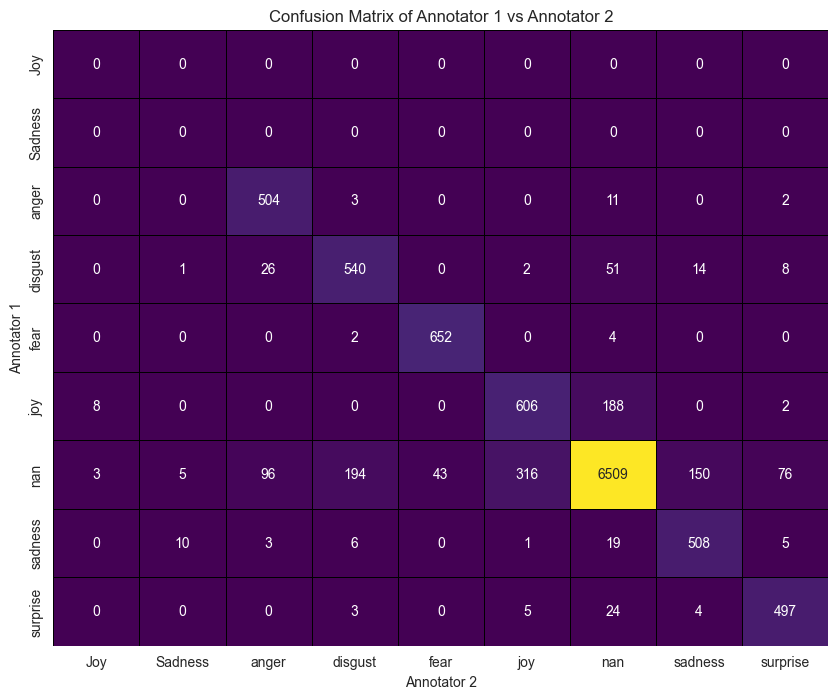

In [104]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(df['emotion_1'],df['emotion_2'])

labels = np.unique(df[['emotion_1', 'emotion_2']].values)
# Create a DataFrame from the confusion matrix for better visualization with seaborn
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis',vmax=cm_df.values.max(), cbar=False, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix of Annotator 1 vs Annotator 2')
plt.xlabel('Annotator 2')
plt.ylabel('Annotator 1')
plt.show()

## Token Length Distribution

In [105]:
df = df.drop_duplicates()

# Optionally, reset the index after dropping duplicates
df = df.reset_index(drop=True)

In [106]:
# Remove columns with empty string as name or unnamed columns
df = df.loc[:, df.columns.str.strip() != '']

In [107]:
# Drop rows with any NaN in any column
df = df.dropna(how='any').reset_index(drop=True)
df.head()

,emotion_1,emotion_2,text
0,joy,joy,නියම සිංහල මහත්මයෙක්.
1,joy,joy,අන්න මිනිස්සු...
2,disgust,anger,හොරා හොද මිනිහෙක් නම් අනේ මහත්තයෝ සමාවෙන්න කිය...
3,nan,nan,තව ඩිංගෙන් ලබු ගෙඩියත් කොස් ගෙඩි සහ පොල් ගෙඩි ...
4,disgust,disgust,"බතල වැලට, කොස්ගෙඩි අටට, උසාවි ගිහින් රිමන්ඩ් ක..."


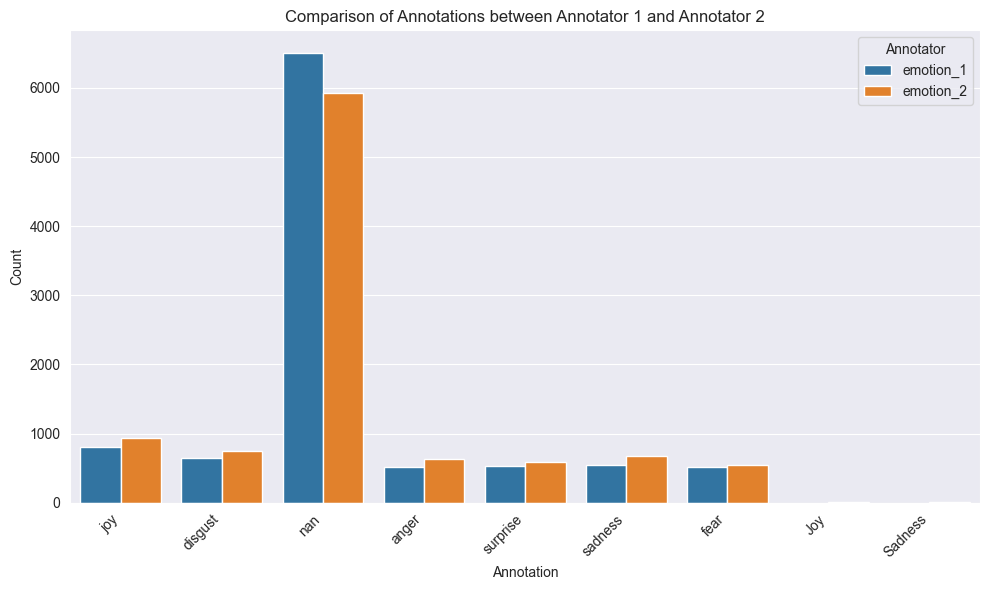

In [108]:
dataset_melted = df[['emotion_1', 'emotion_2']].melt(var_name='Annotator', value_name='Annotation')

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset_melted, x='Annotation', hue='Annotator')
plt.title('Comparison of Annotations between Annotator 1 and Annotator 2')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [109]:

# Keep only rows where both annotators agree
df = df[df['emotion_1'] == df['emotion_2']].copy()

# Create a new 'label' column with the agreed emotion
df['label'] = df['emotion_1']

# Optionally, drop the original columns if not needed
df = df.drop(columns=['emotion_1', 'emotion_2'])

In [110]:
df.head()

,text,label
0,නියම සිංහල මහත්මයෙක්.,joy
1,අන්න මිනිස්සු...,joy
3,තව ඩිංගෙන් ලබු ගෙඩියත් කොස් ගෙඩි සහ පොල් ගෙඩි ...,nan
4,"බතල වැලට, කොස්ගෙඩි අටට, උසාවි ගිහින් රිමන්ඩ් ක...",disgust
9,මට මනුතාපය පොතේ ජනවර්ජන හා පුජක තුමා මතක් උනා ...,nan


In [111]:

# Replace problematic values in 'label' and assign back to the column
df['label'] = df['label'].replace(['', 'nan', 'NaN'], np.nan)
df = df.dropna(subset=['label']).reset_index(drop=True)

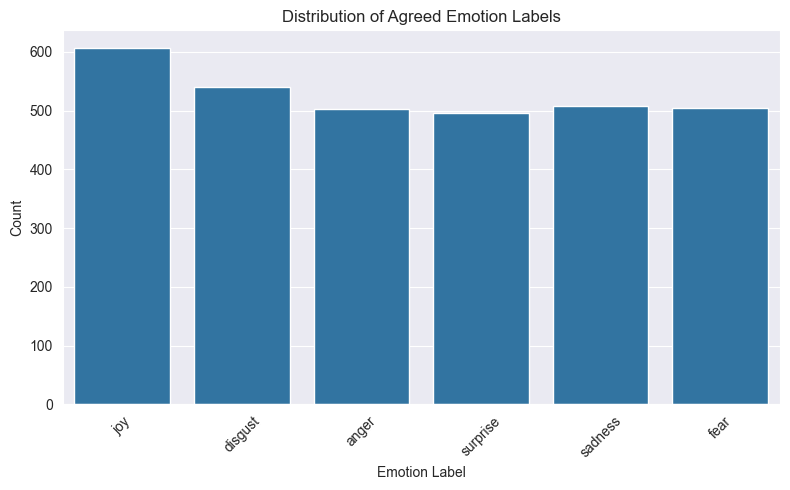

In [112]:

plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Agreed Emotion Labels')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [113]:
# Check the number of samples for each class in the 'label' column
print(df['label'].value_counts())

label
joy         606
disgust     540
sadness     507
fear        504
anger       502
surprise    496
Name: count, dtype: int64


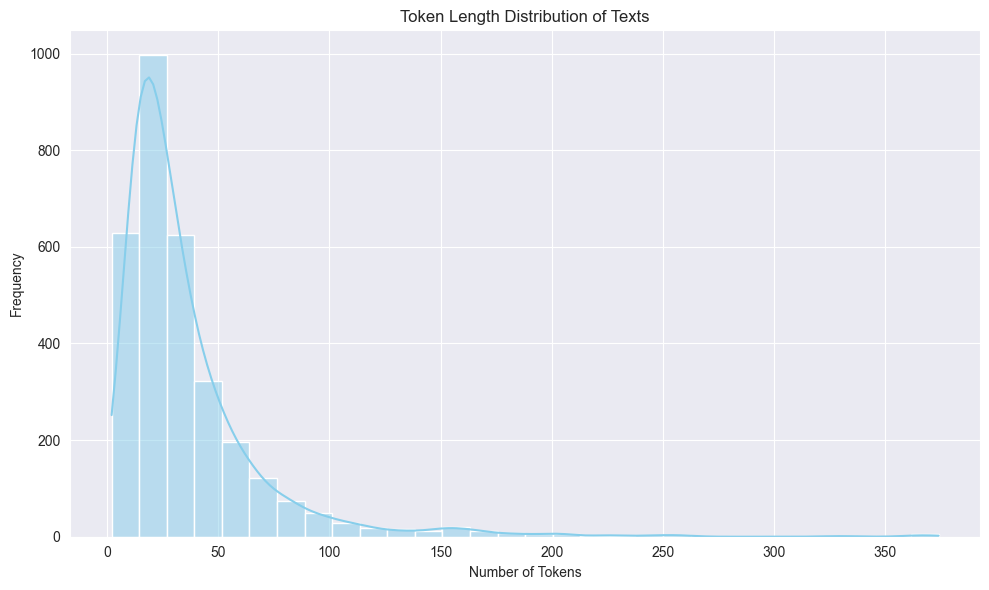

In [114]:
df['token_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(str(x))))

# 2. Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['token_length'], bins=30, kde=True, color='skyblue')
plt.title('Token Length Distribution of Texts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
df.drop(columns=['token_length'], inplace=True)  # Clean up the DataFrame


In [115]:
import os

# Ensure the processed folder exists
os.makedirs('./processed', exist_ok=True)
# Save the DataFrame
df.to_csv('./processed/processed_dataset.csv', index=False, encoding='utf-8')